# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups        
Sample_101  Q9BX67                   18.573
Sample_205  B4DGQ7;P21860;P21860-4   14.457
Sample_105  Q969P0;Q969P0-3          17.805
Sample_030  Q9H3T2;Q9H3T2-3          13.935
Sample_029  Q9NQ30                   14.250
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_021  P04430           15.861
Sample_017  Q7Z7M9           14.309
Sample_162  P06276           17.229
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.576
            A0A075B6Q5                 12.897
            A0A075B6R2                 13.015
            A0A075B6S5                 13.516
            A0A087WSY4                 13.417
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.303
            Q9UI40;Q9UI40-2            12.773
            Q9UIW2                     11.710
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.573
            Q9UP79                     12.196
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.246,15.050,16.842,19.863,15.978,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.858,19.067,...,15.528,15.576,14.170,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.948,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.777,17.705,17.039,16.313,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.774,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.559,15.345,17.084,18.708,14.249,19.433,10.910,11.062
Sample_207,15.739,16.877,15.469,16.898,15.378,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.713,11.766,11.115,13.513,13.025,12.894,12.024,12.528,14.653,12.723
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.037,19.067,16.127,...,13.069,12.219,14.253,13.523,13.252,12.458,13.385,13.374,12.990,13.450
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.976,13.031,12.682,12.933,11.861,14.017,12.818,13.224,13.031,10.661
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.525,11.105,12.354,13.312,11.640,11.493,13.235,13.868,12.094,12.408
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.071,12.413,12.593,12.126,12.699,12.679,12.182,12.244,14.092,14.426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.675,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 334.53it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.35it/s]

100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.92it/s]

100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.78it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.92it/s]

100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.27it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.80it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.22it/s]

100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.10it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.12it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.35it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.52it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.72it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.44it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.12it/s]

100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.19it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.67it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.41it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.29it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.44it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.45it/s]

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.01it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.37it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.98it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.23it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.49it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.56it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.53it/s]

100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.94it/s]

 30%|███       | 3/10 [00:00<00:01,  4.02it/s]

 40%|████      | 4/10 [00:01<00:01,  3.56it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.54it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.41it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.16it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.44it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.48it/s]

100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.53it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.28it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.48it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.48it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.09it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.76it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.45it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.27it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.16it/s]

100%|██████████| 11/11 [00:02<00:00,  3.20it/s]

100%|██████████| 11/11 [00:02<00:00,  3.71it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.49it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.81it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.88it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.62it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.64it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.99it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.62it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.18it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.11it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.11it/s]

100%|██████████| 12/12 [00:03<00:00,  3.30it/s]

100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.70it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.89it/s]

 31%|███       | 4/13 [00:00<00:02,  4.29it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.40it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.26it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.20it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.12it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.51it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.32it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.43it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.24it/s]

100%|██████████| 13/13 [00:03<00:00,  3.31it/s]

100%|██████████| 13/13 [00:03<00:00,  3.81it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.13it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.93it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.53it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.39it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.38it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.04it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.06it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.78it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.50it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.35it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.31it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.13it/s]

100%|██████████| 14/14 [00:03<00:00,  3.15it/s]

100%|██████████| 14/14 [00:03<00:00,  3.74it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.32it/s]

 20%|██        | 3/15 [00:00<00:01,  6.61it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.67it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.53it/s]

 40%|████      | 6/15 [00:01<00:02,  4.27it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.15it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.20it/s]

 60%|██████    | 9/15 [00:01<00:01,  3.93it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.48it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.22it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.08it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.96it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.21it/s]

100%|██████████| 15/15 [00:03<00:00,  3.47it/s]

100%|██████████| 15/15 [00:03<00:00,  3.82it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.066 0.027          0.858 0.236       0.154   
2             0.004 0.003      0.046 0.016          0.675 0.112       0.545   
3             0.006 0.007      0.053 0.021          0.697 0.105       0.628   
4             0.004 0.002      0.047 0.019          0.721 0.098       0.660   
5             0.004 0.003      0.041 0.013          0.702 0.098       0.677   
6             0.004 0.002      0.039 0.010          0.803 0.079       0.797   
7             0.003 0.002      0.044 0.016          0.803 0.079       0.799   
8             0.004 0.003      0.040 0.014          0.801 0.082       0.794   
9             0.004 0.001      0.039 0.011          0.798 0.085       0.781   
10            0.004 0.003      0.040 0.014          0.798 0.086       0.786   
11            0.004 0.004      0.042 0.015          0.814 0.088       0.812   
12            0.004 0.002      0.040 0.016          0.814 0.088       0.820   
13            0.005 0.004      0.046 0.014          0.813 0.088       0.820   
14            0.005 0.003      0.048 0.016          0.819 0.085       0.804   
15            0.004 0.000      0.036 0.004          0.814 0.089       0.798   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.253 0.122                  0.569 0.041        0.855   
2          0.107   0.595 0.085                  0.672 0.062        0.726   
3          0.131   0.650 0.089                  0.709 0.068        0.791   
4          0.111   0.682 0.077                  0.733 0.061        0.819   
5          0.113   0.684 0.085                  0.731 0.070        0.817   
6          0.110   0.795 0.071                  0.826 0.058        0.897   
7          0.108   0.796 0.071                  0.827 0.059        0.895   
8          0.103   0.793 0.070                  0.824 0.058        0.895   
9          0.105   0.785 0.073                  0.817 0.060        0.893   
10         0.107   0.787 0.076                  0.819 0.063        0.896   
11         0.101   0.809 0.072                  0.836 0.062        0.906   
12         0.092   0.813 0.071                  0.840 0.061        0.905   
13         0.094   0.813 0.072                  0.840 0.062        0.904   
14         0.101   0.808 0.076                  0.836 0.063        0.911   
15         0.101   0.802 0.077                  0.831 0.065        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.088        210.000 0.000  
2          0.079                  0.683 0.100        210.000 0.000  
3          0.072                  0.719 0.095        210.000 0.000  
4          0.063                  0.783 0.088        210.000 0.000  
5          0.059                  0.778 0.088        210.000 0.000  
6          0.046                  0.869 0.060        210.000 0.000  
7          0.047                  0.867 0.061        210.000 0.000  
8          0.049                  0.866 0.064        210.000 0.000  
9          0.050                  0.864 0.063        210.000 0.000  
10         0.050                  0.873 0.059        210.000 0.000  
11         0.050                  0.889 0.056        210.000 0.000  
12         0.052                  0.891 0.054        210.000 0.000  
13         0.052                  0.891 0.054        210.000 0.000  
14         0.049                  0.900 0.050        210.000 0.000  
15         0.050                  0.898 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 540.92it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.34it/s]

100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.08it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.10it/s]

100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.15it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.83it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.15it/s]

100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.03it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.56it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.47it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.79it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.48it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.95it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.76it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.71it/s]

100%|██████████| 7/7 [00:01<00:00,  3.49it/s]

100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.01it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.98it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.16it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.72it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.60it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.68it/s]

100%|██████████| 8/8 [00:02<00:00,  3.59it/s]

100%|██████████| 8/8 [00:02<00:00,  3.91it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.24it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.88it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.62it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.33it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.22it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.25it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.32it/s]

100%|██████████| 9/9 [00:03<00:00,  2.22it/s]

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.92it/s]

 30%|███       | 3/10 [00:00<00:02,  3.01it/s]

 40%|████      | 4/10 [00:01<00:02,  2.94it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.04it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.19it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.09it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.12it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.18it/s]

100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.91it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.72it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.42it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.52it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.52it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.90it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.64it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.48it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.57it/s]

100%|██████████| 11/11 [00:03<00:00,  2.49it/s]

100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.24it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.98it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.66it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.53it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.73it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.85it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.92it/s]

 75%|███████▌  | 9/12 [00:03<00:00,  3.04it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.06it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.14it/s]

100%|██████████| 12/12 [00:03<00:00,  3.19it/s]

100%|██████████| 12/12 [00:03<00:00,  3.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.76it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.78it/s]

 31%|███       | 4/13 [00:01<00:02,  3.38it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.29it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.14it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.23it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.81it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.61it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.50it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.50it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.49it/s]

100%|██████████| 13/13 [00:04<00:00,  2.47it/s]

100%|██████████| 13/13 [00:04<00:00,  2.82it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.13it/s]

 21%|██▏       | 3/14 [00:01<00:03,  2.78it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.39it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.20it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.34it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.59it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.76it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.69it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.82it/s]

 79%|███████▊  | 11/14 [00:04<00:00,  3.01it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.93it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.08it/s]

100%|██████████| 14/14 [00:04<00:00,  3.11it/s]

100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.64it/s]

 20%|██        | 3/15 [00:00<00:03,  3.94it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.97it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.85it/s]

 40%|████      | 6/15 [00:01<00:02,  3.70it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.62it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.72it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.51it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.67it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.52it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.66it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.14it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.00it/s]

100%|██████████| 15/15 [00:04<00:00,  2.83it/s]

100%|██████████| 15/15 [00:04<00:00,  3.43it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.038 0.007          0.010 0.071       0.001   
2             0.004 0.003      0.046 0.019          0.698 0.117       0.522   
3             0.004 0.004      0.044 0.018          0.752 0.111       0.622   
4             0.004 0.004      0.047 0.015          0.782 0.104       0.606   
5             0.003 0.002      0.037 0.012          0.769 0.081       0.640   
6             0.003 0.002      0.029 0.006          0.780 0.088       0.684   
7             0.004 0.002      0.035 0.006          0.777 0.095       0.703   
8             0.003 0.000      0.033 0.008          0.785 0.090       0.789   
9             0.004 0.004      0.043 0.021          0.775 0.093       0.784   
10            0.005 0.006      0.053 0.017          0.779 0.094       0.796   
11            0.004 0.003      0.039 0.013          0.803 0.100       0.781   
12            0.005 0.004      0.055 0.022          0.818 0.094       0.783   
13            0.005 0.003      0.045 0.018          0.820 0.094       0.790   
14            0.005 0.007      0.051 0.019          0.820 0.095       0.788   
15            0.005 0.003      0.047 0.019          0.817 0.096       0.779   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.857   
2          0.132   0.588 0.110                  0.676 0.075        0.736   
3          0.129   0.671 0.099                  0.732 0.067        0.782   
4          0.118   0.675 0.094                  0.739 0.063        0.797   
5          0.118   0.691 0.084                  0.748 0.056        0.801   
6          0.122   0.722 0.086                  0.770 0.064        0.818   
7          0.129   0.731 0.092                  0.776 0.071        0.822   
8          0.115   0.781 0.077                  0.814 0.063        0.891   
9          0.111   0.774 0.078                  0.807 0.065        0.888   
10         0.120   0.782 0.086                  0.814 0.073        0.891   
11         0.127   0.785 0.088                  0.818 0.073        0.909   
12         0.125   0.794 0.088                  0.826 0.071        0.913   
13         0.122   0.799 0.089                  0.831 0.073        0.914   
14         0.123   0.798 0.089                  0.829 0.073        0.913   
15         0.112   0.791 0.078                  0.823 0.064        0.913   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.826 0.088        210.000 0.000  
2          0.077                  0.669 0.097        210.000 0.000  
3          0.074                  0.753 0.091        210.000 0.000  
4          0.073                  0.774 0.087        210.000 0.000  
5          0.070                  0.779 0.084        210.000 0.000  
6          0.074                  0.791 0.088        210.000 0.000  
7          0.075                  0.792 0.091        210.000 0.000  
8          0.053                  0.861 0.063        210.000 0.000  
9          0.054                  0.857 0.064        210.000 0.000  
10         0.054                  0.866 0.063        210.000 0.000  
11         0.048                  0.878 0.064        210.000 0.000  
12         0.047                  0.887 0.059        210.000 0.000  
13         0.047                  0.890 0.056        210.000 0.000  
14         0.047                  0.889 0.057        210.000 0.000  
15         0.047                  0.892 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1374.73it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 25.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.95it/s]

100%|██████████| 3/3 [00:00<00:00, 18.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 23.06it/s]

100%|██████████| 4/4 [00:00<00:00, 17.84it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.86it/s]

100%|██████████| 5/5 [00:00<00:00, 14.65it/s]

100%|██████████| 5/5 [00:00<00:00, 14.93it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.80it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 16.67it/s]

100%|██████████| 6/6 [00:00<00:00, 17.37it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 26.53it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.21it/s]

100%|██████████| 7/7 [00:00<00:00, 17.17it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.16it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.61it/s]

100%|██████████| 8/8 [00:00<00:00, 18.12it/s]

100%|██████████| 8/8 [00:00<00:00, 18.48it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.26it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.69it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.91it/s]

100%|██████████| 9/9 [00:00<00:00, 15.51it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 24.31it/s]

 60%|██████    | 6/10 [00:00<00:00, 19.69it/s]

 90%|█████████ | 9/10 [00:00<00:00, 17.10it/s]

100%|██████████| 10/10 [00:00<00:00, 17.46it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.21it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 19.84it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 16.65it/s]

100%|██████████| 11/11 [00:00<00:00, 15.42it/s]

100%|██████████| 11/11 [00:00<00:00, 16.56it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.90it/s]

 50%|█████     | 6/12 [00:00<00:00, 18.66it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 18.51it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 18.94it/s]

100%|██████████| 12/12 [00:00<00:00, 18.51it/s]

100%|██████████| 12/12 [00:00<00:00, 18.72it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.07it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.00it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.35it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.62it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 15.51it/s]

100%|██████████| 13/13 [00:00<00:00, 15.52it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.46it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.56it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.16it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 14.03it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 14.38it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 14.05it/s]

100%|██████████| 14/14 [00:00<00:00, 14.68it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.74it/s]

 40%|████      | 6/15 [00:00<00:00, 15.22it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.46it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 13.03it/s]

 80%|████████  | 12/15 [00:00<00:00, 12.59it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.32it/s]

100%|██████████| 15/15 [00:01<00:00, 13.41it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.035 0.012          0.000 0.000       0.000   
2             0.004 0.003      0.044 0.016          0.616 0.095       0.454   
3             0.003 0.002      0.032 0.006          0.610 0.107       0.411   
4             0.004 0.002      0.047 0.016          0.690 0.081       0.588   
5             0.003 0.000      0.034 0.008          0.683 0.089       0.583   
6             0.003 0.001      0.046 0.017          0.726 0.091       0.631   
7             0.004 0.002      0.041 0.014          0.720 0.084       0.627   
8             0.005 0.004      0.046 0.015          0.690 0.082       0.614   
9             0.004 0.002      0.041 0.017          0.687 0.090       0.625   
10            0.005 0.005      0.047 0.015          0.698 0.087       0.627   
11            0.005 0.007      0.040 0.012          0.688 0.084       0.628   
12            0.004 0.004      0.034 0.012          0.686 0.086       0.614   
13            0.004 0.002      0.042 0.015          0.666 0.092       0.601   
14            0.004 0.002      0.039 0.012          0.665 0.086       0.597   
15            0.006 0.006      0.051 0.025          0.660 0.083       0.603   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.737   
2          0.102   0.515 0.082                  0.621 0.055        0.687   
3          0.104   0.483 0.089                  0.607 0.057        0.700   
4          0.101   0.629 0.070                  0.696 0.052        0.789   
5          0.105   0.623 0.076                  0.690 0.058        0.785   
6          0.111   0.667 0.072                  0.725 0.054        0.803   
7          0.110   0.663 0.076                  0.722 0.057        0.801   
8          0.113   0.644 0.078                  0.705 0.060        0.797   
9          0.120   0.647 0.084                  0.706 0.064        0.797   
10         0.118   0.652 0.078                  0.712 0.058        0.797   
11         0.113   0.649 0.076                  0.707 0.058        0.793   
12         0.106   0.641 0.073                  0.701 0.055        0.791   
13         0.109   0.625 0.079                  0.687 0.060        0.785   
14         0.114   0.622 0.080                  0.686 0.059        0.783   
15         0.107   0.623 0.073                  0.685 0.056        0.780   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.693 0.083        210.000 0.000  
2          0.066                  0.650 0.071        210.000 0.000  
3          0.066                  0.656 0.074        210.000 0.000  
4          0.060                  0.749 0.068        210.000 0.000  
5          0.060                  0.747 0.068        210.000 0.000  
6          0.058                  0.771 0.068        210.000 0.000  
7          0.058                  0.768 0.069        210.000 0.000  
8          0.059                  0.763 0.069        210.000 0.000  
9          0.059                  0.758 0.072        210.000 0.000  
10         0.058                  0.754 0.074        210.000 0.000  
11         0.058                  0.749 0.075        210.000 0.000  
12         0.061                  0.745 0.079        210.000 0.000  
13         0.063                  0.739 0.082        210.000 0.000  
14         0.061                  0.742 0.079        210.000 0.000  
15         0.063                  0.738 0.082 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,3,10,15
score_time,1,12,15
test_precision,1,13,6
test_recall,12,10,6
test_f1,12,13,6
test_balanced_accuracy,12,13,6
test_roc_auc,14,13,6
test_average_precision,14,15,6
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.98it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.72it/s]

 31%|███       | 4/13 [00:01<00:03,  2.77it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.57it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.60it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.83it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.05it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  3.13it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.18it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.22it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.19it/s]

100%|██████████| 13/13 [00:04<00:00,  3.15it/s]

100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.57it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.07it/s]

100%|██████████| 6/6 [00:00<00:00, 14.90it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.25it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.28it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.04it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.47it/s]

 43%|████▎     | 6/14 [00:00<00:01,  5.86it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.85it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.84it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.58it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.54it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.41it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  5.30it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.19it/s]

100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


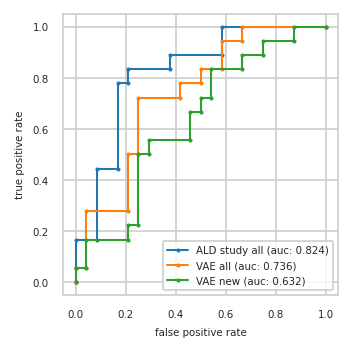

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.167   0.042 0.056   0.042 0.056
3          0.083 0.167   0.042 0.278   0.042 0.167
4          0.083 0.444   0.208 0.278   0.208 0.167
5          0.167 0.444   0.208 0.500   0.208 0.222
6          0.167 0.778   0.250 0.500   0.250 0.222
7          0.208 0.778   0.250 0.722   0.250 0.500
8          0.208 0.833   0.417 0.722   0.292 0.500
9          0.375 0.833   0.417 0.778   0.292 0.556
10         0.375 0.889   0.500 0.778   0.458 0.556
11         0.583 0.889   0.500 0.833   0.458 0.667
12         0.583 1.000   0.583 0.833   0.500 0.667
13         1.000 1.000   0.583 0.944   0.500 0.722
14           NaN   NaN   0.667 0.944   0.542 0.722
15           NaN   NaN   0.667 1.000   0.542 0.833
16           NaN   NaN   1.000 1.000   0.667 0.833
17           NaN   NaN     NaN   NaN   0.667 0.889
18           NaN   NaN     NaN   NaN   0.750 0.889
19           NaN   NaN     NaN   NaN   0.750 0.944
20           NaN   NaN     NaN   NaN   0.875 0.944
21           NaN   NaN     NaN   NaN   0.875 1.000
22           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q15848,K7ER15;Q9H0R4;Q9H0R4-2,P43004;P43004-2;P43004-3
2,P01597;P04432,A0A140T913;A0A140T933;A0A140T955;A0A140T9I0;A0...,P31150
3,P61981,Q9Y2T3;Q9Y2T3-3,Q96GD0
4,P04075,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P14174,P04075,Q9NUQ9
6,P00338;P00338-3,P14174,None
7,Q9Y2T3;Q9Y2T3-3,Q14894,None
8,P25189;P25189-2,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


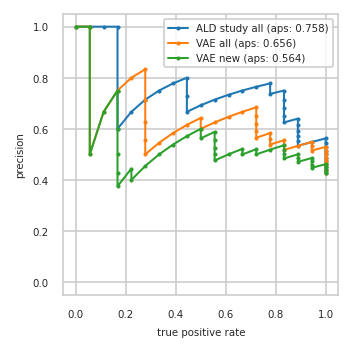

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.515 0.944     0.485 0.889
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.533 0.889     0.533 0.889     0.500 0.833
13         0.552 0.889     0.517 0.833     0.517 0.833
14         0.571 0.889     0.536 0.833     0.536 0.833
15         0.593 0.889     0.556 0.833     0.519 0.778
16         0.615 0.889     0.538 0.778     0.500 0.722
17         0.640 0.889     0.560 0.778     0.520 0.722
18         0.625 0.833     0.583 0.778     0.500 0.667
19         0.652 0.833     0.565 0.722     0.522 0.667
20         0.682 0.833     0.591 0.722     0.500 0.611
21         0.714 0.833     0.619 0.722     0.476 0.556
22         0.750 0.833     0.650 0.722     0.500 0.556
23         0.737 0.778     0.684 0.722     0.526 0.556
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.765 0.722     0.647 0.611     0.588 0.556
26         0.750 0.667     0.625 0.556     0.562 0.500
27         0.733 0.611     0.600 0.500     0.600 0.500
28         0.714 0.556     0.643 0.500     0.571 0.444
29         0.692 0.500     0.615 0.444     0.538 0.389
30         0.667 0.444     0.583 0.389     0.500 0.333
31         0.727 0.444     0.545 0.333     0.455 0.278
32         0.800 0.444     0.500 0.278     0.400 0.222
33         0.778 0.389     0.556 0.278     0.444 0.222
34         0.750 0.333     0.625 0.278     0.375 0.167
35         0.714 0.278     0.714 0.278     0.429 0.167
36         0.667 0.222     0.833 0.278     0.500 0.167
37         0.600 0.167     0.800 0.222     0.600 0.167
38         0.750 0.167     0.750 0.167     0.750 0.167
39         1.000 0.167     0.667 0.111     0.667 0.111
40         1.000 0.111     0.500 0.056     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


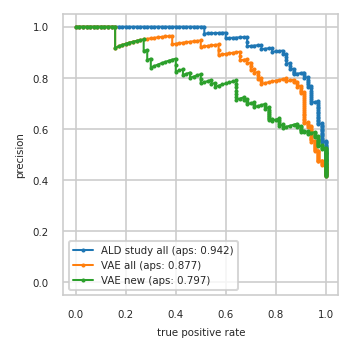

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


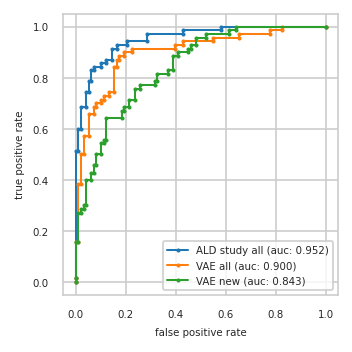

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}